In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble as skl_en
import sklearn.model_selection as skl_ms
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer  # Imported make_scorer
)
import matplotlib.pyplot as plt

df = pd.read_csv("training.csv")

# Split the data into training and testing sets (80%-20%)
X = df.drop(columns=['increase_stock'])  # Features
y = df['increase_stock']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y
)

# Preprocessing: Cyclic encoding for 'hour_of_day', 'day_of_week', and 'month'
for df_split in [X_train, X_test]:
    df_split.loc[:, 'hour_sin'] = np.sin(2 * np.pi * df_split['hour_of_day'] / 24)
    df_split.loc[:, 'hour_cos'] = np.cos(2 * np.pi * df_split['hour_of_day'] / 24)
    df_split.loc[:, 'day_sin'] = np.sin(2 * np.pi * df_split['day_of_week'] / 7)
    df_split.loc[:, 'day_cos'] = np.cos(2 * np.pi * df_split['day_of_week'] / 7)
    df_split.loc[:, 'month_sin'] = np.sin(2 * np.pi * df_split['month'] / 12)
    df_split.loc[:, 'month_cos'] = np.cos(2 * np.pi * df_split['month'] / 12)

# Selecting final features (exclude original cyclic columns)
final_features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
    'weekday', 'summertime', 'temp', 'humidity', 'precip', 'windspeed', 'visibility','snow', 'holiday', 'snowdepth'
]

X_train = X_train[final_features]
X_test = X_test[final_features]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Xtr = X_train_scaled
Ytr = y_train



0.096875
                  precision    recall  f1-score   support

high_bike_demand       0.75      0.69      0.72        58
 low_bike_demand       0.93      0.95      0.94       262

        accuracy                           0.90       320
       macro avg       0.84      0.82      0.83       320
    weighted avg       0.90      0.90      0.90       320



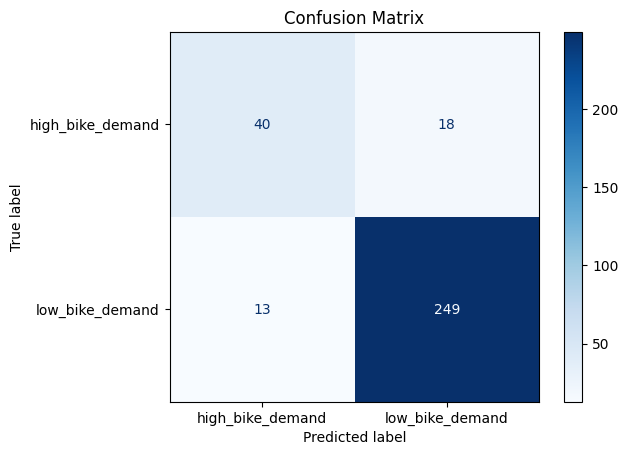

In [2]:
np.random.seed(16)
modelfinal = skl_en.RandomForestClassifier(n_estimators=50000, max_features=4, oob_score=True)
modelfinal.fit(Xtr, Ytr)
ypr = modelfinal.predict(X_test_scaled)

# Print the mean error and classification report
print(np.mean(y_test != ypr))
print(classification_report(y_test, ypr))

# Confusion Matrix
cm = confusion_matrix(y_test, ypr)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelfinal.classes_)
cm_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



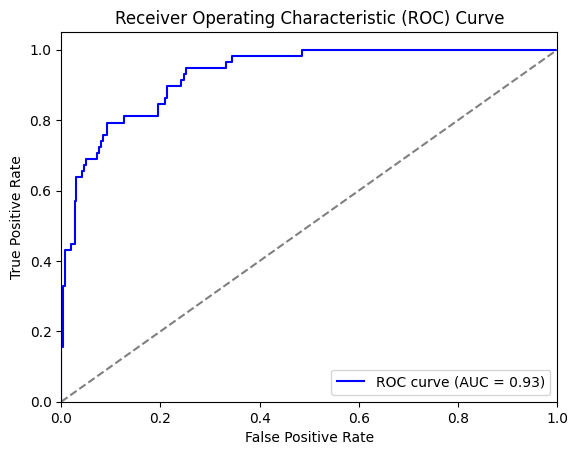

In [3]:
# ROC Curve
ypra = modelfinal.predict_proba(X_test_scaled)
fp, fn, _ = roc_curve(y_test == 'high_bike_demand', ypra[:, 0])
auc = roc_auc_score(y_test == 'high_bike_demand', ypra[:, 0])
plt.figure()
plt.plot(fp, fn, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




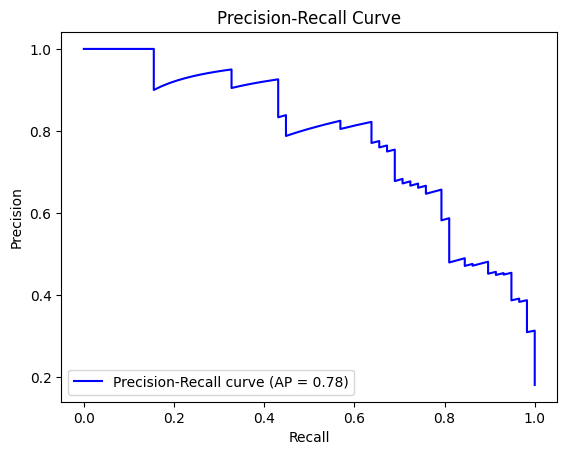

In [5]:
# Precision-Recall Curve with Average Precision (AP)
prec, rec, _ = precision_recall_curve(y_test == 'high_bike_demand', ypra[:, 0])
ap_score = sklearn.metrics.average_precision_score(y_test == 'high_bike_demand', ypra[:, 0])

plt.figure()
plt.plot(rec, prec, color='blue', label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
